## Use k-Means clustering on economic, racial, age, district size, mean distance in voting behavior

- get dataframe from CSVs
- construct desired sets of predictors
- prepare labels
- run cluster algo
- encode clusters into existing data frame
- visual clusters
- identify cluster-defining properties

In [266]:
import pandas as pd
import numpy as np
from sklearn import cluster as skclust
from sklearn import preprocessing as skproc
from sklearn import metrics as skmetric
import matplotlib.pyplot as plt
import time
import re
%matplotlib inline
import seaborn as sns


In [356]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_style("ticks", {'legend.frameon' : True })
sns.set_palette(sns.color_palette(flatui))

In [319]:
df = pd.read_csv("data/county_facts.csv")

In [311]:
rename_map={"PST045214": "Pop2014",
            "PST040210": "Pop2010EST",
            "PST120214": "Pop%Change",
            "POP010210": "Pop2010",
            "AGE135214": "Under5%",
            "AGE295214": "Under18%",
            "AGE775214": "Over65%",
            "SEX255214": "Female%",
            "RHI125214": "White%",
            "RHI225214": "Black%",
            "RHI325214": "NativeA%",
            "RHI425214": "Asian%",
            "RHI525214": "PIsland%",
            "RHI625214": "TwoRace%",
            "RHI725214": "Latino",
            "RHI825214": "WhiteNLat%",
            "POP715213": "SameHouse1yr%",
            "POP645213": "ForeignBorn%",
            "POP815213": "NonEnglish%",
            "EDU635213": "HighSchoolGrad%",
            "EDU685213": "Bachelor%",
            "VET605213": "Veteran",
            "LFE305213": "TravelTime",
            "HSG010214": "HousingUnits",
            "HSG445213": "OwnershipRate",
            "HSG096213": "UnitsinMultiUnit%",
            "HSG495213": "MedianValueHousing",
            "HSD410213": "Households",
            "INC910213": "PerCapitaIncome",
            "INC110213": "MedianIncome",
            "PVY020213": "%BelowPoverty",
            "BZA010213": "PrivateNotFarmsEstablish",
            "BZA110213": "PrivateNotFarmEmploy",
            "BZA115213": "NotFarm%Change",
            "NES010213": "NonEmployerEstablish",
            "SBO315207": "Black-owned%",
            "SBO115207": "Native-owned%",
            "SBO215207": "Asian-owned%",
            "SBO515207": "PIslnder-owned%",
            "SBO415207": "Hispanic-owned%",
            "SBO015207": "Woman-owned",
            "MAN450207": "Manfact shipments 1k",
            "WTN220207": "Merchant sales 1k",
            "RTN130207": "Retail sales 1k",
            "RTN131207": "Retail sales/capita",
            "AFN120207": "Accomd/FoodServ sales 1k",
            "BPS030214": "BuildingPermits",
            "LND110210": "LandArea",
            "POP060210": "Pop/SqMile"}

df=df.rename(index=str,columns=rename_map)


In [164]:
## aggregate state/national data hold NaN values in state_abbrev
counties = df.dropna()
not_counties = df[~df.index.isin(counties.index)]

In [165]:
cf_dict = pd.read_csv("data/county_facts_dictionary.csv")
cf_dict = cf_dict.rename(index=str,columns=rename_map)

In [166]:
cf_dict.head()

,column_name,description
0,PST045214,"Population, 2014 estimate"
1,PST040210,"Population, 2010 (April 1) estimates base"
2,PST120214,"Population, percent change - April 1, 2010 to ..."
3,POP010210,"Population, 2010"
4,AGE135214,"Persons under 5 years, percent, 2014"


In [167]:
vote_data = pd.read_csv("data/US_County_Level_Presidential_Results_12-16.csv").rename(columns={"FIPS":"fips"})
rm = ['combined_fips', 'state_abbr', 'Unnamed: 0', 'county_name', 'county_fips', 'state_fips']
counties = pd.merge(counties, vote_data, on="fips").drop(rm, axis=1).dropna()
### LOSE ALASKAN COUNTY DATA


Make subsets for various clustering parameters.

In [168]:
#### Population/Age/Education
#
age_pop_edu_predictors = ["Pop%Change", "Under5%","Under18%", "Over65%",
                          "HighSchoolGrad%","Bachelor%", "Veteran"]
### HOUSING 
housing_predictors = ["SameHouse1yr%", "TravelTime", "HousingUnits", "OwnershipRate", "UnitsinMultiUnit%",
                        "MedianValueHousing", "Households"]
### ECONOMIC
econ_predictors = ["PerCapitaIncome", "MedianIncome", "%BelowPoverty","Manfact shipments 1k",
                   "Merchant sales 1k", "Retail sales/capita", "Retail sales/capita", "BuildingPermits"]
##### ETHNIC 
racial_predictors = ["Female%", "White%", "Black%","NativeA%","Asian%","PIsland%",
                     "TwoRace%","Latino","WhiteNLat%","ForeignBorn%", "NonEnglish%"]
## HYBRID
econ_plus_race = econ_predictors + racial_predictors

#### ETHNIC BUSINESS
ownership_predictors = ["Black-owned%","Native-owned%","Asian-owned%","PIslnder-owned%","Woman-owned"]

## VOTING
vote_predictors = ['per_dem_2016', 'per_gop_2016', 'per_point_diff_2016',
                   'per_dem_2012', 'per_gop_2012', 'per_point_diff_2012', "turnout_2016", "turnout_2012"]


create some features for voting date to determine turnout

In [169]:
counties["turnout_2016"] = counties.total_votes_2016 / counties.Pop2014
counties["turnout_2012"] = counties.total_votes_2012 / counties.Pop2010

In [170]:
X_dict={"age_pop_edu": age_pop_edu_predictors, "economic": econ_predictors, "ethnic": racial_predictors,
        "housing": housing_predictors, "ownership_race": ownership_predictors,
        "voting": vote_predictors, "econ_race": econ_plus_race}

### Silhouette Analysis for tuning k 

In [171]:
def encode_clusters(data, col_key, label_mat, kth_score, best_k_dict, descrip):
    best_k_dict[descrip] = np.argmax(kth_score[descrip]) + 2
    data[col_key] = label_mat[best_k_dict[descrip]-2] ## store labels for best k
    data = pd.get_dummies(data, columns=[col_key])        
    data[col_key] = label_mat[best_k_dict[descrip] - 2] ##replace what get_dummies removed
    return data, best_k_dict

##### kMeans clustering.

In [172]:
def cluster_experiment_kmeans(data, predictor_lists:dict, max_clusters=20, scoring="sil"):
    start = time.time()
    best_k_dict = {}
    col_names = []
    kth_score = {}
    for descrip, X in predictor_lists.items():
        kth_score[descrip] = []
        label_mat = []
        col_key = descrip + "_kmeans"
        #normalize feature space
        X = skproc.normalize(data[X])
        
        ## run kmeans for each k [0,max_cluster]
        for k in range(2, max_clusters):
            kmeans = skclust.KMeans(n_clusters=k, n_jobs=-1, precompute_distances=True)
            kmeans.fit_predict(X)
            label_mat.append(kmeans.labels_)
            ##silhouette analysis
            if scoring == "sil":
                kth_score[descrip].append(skmetric.silhouette_score(X, label_mat[k - 2]))
            else:
                kth_score[descrip].append(skmetric.calinski_harabaz_score(X, label_mat[k - 2]))            

        ## add best cluster set to dataframe
        data, best_k_dict = encode_clusters(data, col_key, label_mat, kth_score, best_k_dict, descrip)
        #update with th new column names
        col_names.extend([col_key+"_"+str(int(k)) for k in range(best_k_dict[descrip])])
    
    print("Runtime: ", time.time() - start)
    return data, col_names, best_k_dict, kth_score
            
                

##### Agglomerative clustering.

In [173]:
def cluster_experiment_agglom(data, predictor_lists:dict, max_clusters=20, scoring="sil"):
    start = time.time()
    best_k_dict = {}
    col_names = []
    kth_score = {}
    for descrip, X in predictor_lists.items():
        kth_score[descrip] = []
        label_mat = []
        col_key = descrip + "_agglo"
        #normalize feature space
        X = skproc.normalize(data[X])

        for k in range(2, max_clusters):
            agglo = skclust.AgglomerativeClustering(n_clusters=k)
            agglo.fit_predict(X)
            ##silhouette analysis
            label_mat.append(agglo.labels_)
            if scoring == "sil":
                kth_score[descrip].append(skmetric.silhouette_score(X, label_mat[k - 2]))
            else:
                kth_score[descrip].append(skmetric.calinski_harabaz_score(X, label_mat[k - 2]))

        ## add best cluster set to dataframe
        data, best_k_dict = encode_clusters(data, col_key, label_mat, kth_score, best_k_dict, descrip)
        #update with th new column names
        col_names.extend([col_key+"_"+str(int(k)) for k in range(best_k_dict[descrip])])

    print("Runtime: ", time.time() - start)
    return data, col_names, best_k_dict, kth_score

##### Spectral Clustering

In [174]:
def cluster_experiment_spectral(data, predictor_lists:dict, max_clusters=5, scoring="sil"):
    start = time.time()
    best_k_dict = {}
    col_names = []
    kth_score = {}
    for descrip, X in predictor_lists.items():
        kth_score[descrip] = []
        label_mat = []
        col_key = descrip + "_spectral"
        #normalize feature space
        X = skproc.normalize(data[X])
        
        ## run kmeans for each k [0,max_cluster]
        for k in range(2, max_clusters):
            spec = skclust.SpectralClustering(n_clusters=k, n_jobs=-1)
            spec.fit_predict(X)
            ##silhouette analysis
            label_mat.append(spec.labels_)
            if scoring == "sil":
                kth_score[descrip].append(skmetric.silhouette_score(X, label_mat[k - 2]))
            else:
                kth_score[descrip].append(skmetric.calinski_harabaz_score(X, label_mat[k - 2]))
        ## add best cluster set to dataframe
        data, best_k_dict = encode_clusters(data, col_key, label_mat, kth_score, best_k_dict, descrip)
        print("Processed - ", descrip)
        #update with th new column names
        col_names.extend([col_key+"_"+str(int(k)) for k in range(best_k_dict[descrip])])

    print("Runtime: ", time.time() - start)
    return data, col_names, best_k_dict, kth_score

### Construct Feature Sets

In [175]:
for x in X_dict:
    print(x, "\n  "+ str(X_dict[x]), "\n")

economic 
  ['PerCapitaIncome', 'MedianIncome', '%BelowPoverty', 'Manfact shipments 1k', 'Merchant sales 1k', 'Retail sales/capita', 'Retail sales/capita', 'BuildingPermits'] 

ethnic 
  ['Female%', 'White%', 'Black%', 'NativeA%', 'Asian%', 'PIsland%', 'TwoRace%', 'Latino', 'WhiteNLat%', 'ForeignBorn%', 'NonEnglish%'] 

voting 
  ['per_dem_2016', 'per_gop_2016', 'per_point_diff_2016', 'per_dem_2012', 'per_gop_2012', 'per_point_diff_2012', 'turnout_2016', 'turnout_2012'] 

econ_race 
  ['PerCapitaIncome', 'MedianIncome', '%BelowPoverty', 'Manfact shipments 1k', 'Merchant sales 1k', 'Retail sales/capita', 'Retail sales/capita', 'BuildingPermits', 'Female%', 'White%', 'Black%', 'NativeA%', 'Asian%', 'PIsland%', 'TwoRace%', 'Latino', 'WhiteNLat%', 'ForeignBorn%', 'NonEnglish%'] 

housing 
  ['SameHouse1yr%', 'TravelTime', 'HousingUnits', 'OwnershipRate', 'UnitsinMultiUnit%', 'MedianValueHousing', 'Households'] 

ownership_race 
  ['Black-owned%', 'Native-owned%', 'Asian-owned%', 'PIslnder-

### Run cluster analysis on each list of predictors.
#### kMeans, where 2 <= k < 20

In [176]:
counties, kmeans_dummies, kmeans_k_dict, kmeans_sil_scores = cluster_experiment_kmeans(counties, X_dict)

Runtime:  113.66365933418274


##### Agglomerative, where 2 <= k < 20 using average linkage.

In [177]:
counties, agglo_dummies, agglo_k_dict, agglo_sil_scores = cluster_experiment_agglom(counties, X_dict)

Runtime:  69.71641993522644


#### Spectral cluster, using Nearest Neighbors Affinity for 2 <= k < 15

In [178]:
counties, spec_dummies, spec_k_dict, spec_sil_scores = cluster_experiment_spectral(counties, X_dict)

Processed -  economic
Processed -  ethnic
Processed -  voting
Processed -  econ_race
Processed -  housing
Processed -  ownership_race
Processed -  age_pop_edu
Runtime:  33.06241989135742


### At this point, the clusters each clustering method is encoded into dataframe.

In [326]:
prefix=agglo_sil_scores.keys()


ss = {"kmeans":kmeans_sil_scores, "agglo": agglo_sil_scores, "spectral":spec_sil_scores}
clust = ["kmeans", "agglo", "spectral"]

agglo_scores = {p+"_agglo_ss" : agglo_sil_scores[p] for p in agglo_sil_scores}
kmeans_scores = {p+"_kmeans_ss" : kmeans_sil_scores[p] for p in kmeans_sil_scores}
spec_scores = {p+"_spec_ss" : spec_sil_scores[p] for p in spec_sil_scores}

agglo_scores

# merged_scores = { p + "_sil" : [kmeans_sil_scores[p], agglo_sil_scores[p],spec_sil_scores[p]] for p in prefix}
agg = pd.DataFrame(agglo_scores, index=list(range(2, 20)))
kmn = pd.DataFrame(kmeans_scores, index=list(range(2, 20)))
spec = pd.DataFrame(spec_scores, index=list(range(2, 5)))

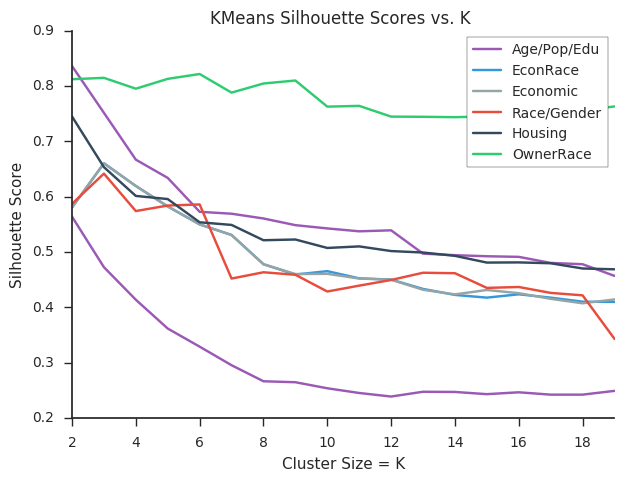

In [357]:
p1 = kmn.plot(kind='line', title="KMeans Silhouette Scores vs. K ",figsize=(7,5), alpha=1)
sns.despine()
leg1 = ["Age/Pop/Edu", "EconRace","Economic", "Race/Gender", "Housing", "OwnerRace"]
handles, labels = p1.get_legend_handles_labels()
plt.legend(handles, leg1, loc=1)
plt.ylabel('Silhouette Score')
plt.xlabel('Cluster Size = K')
plt.savefig("kmeans_sscores")

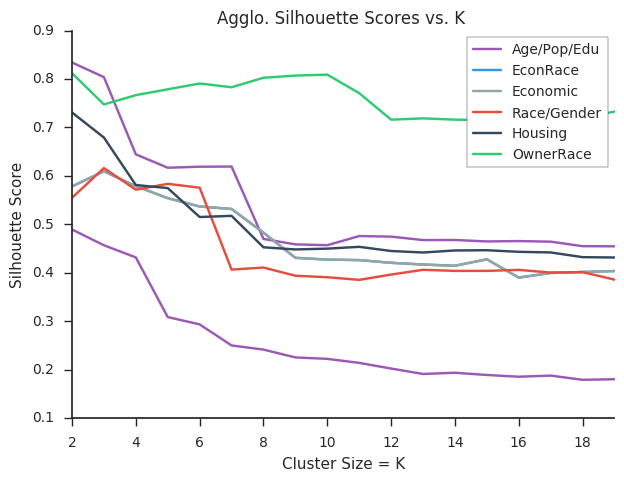

In [358]:
agg.plot(kind='line', title="Agglo. Silhouette Scores vs. K ",figsize=(7,5))
sns.despine()
handles, labels = p1.get_legend_handles_labels()
plt.legend(handles, leg1, loc=1)
plt.ylabel('Silhouette Score')
plt.xlabel('Cluster Size = K')
plt.savefig("agglo_sscores")


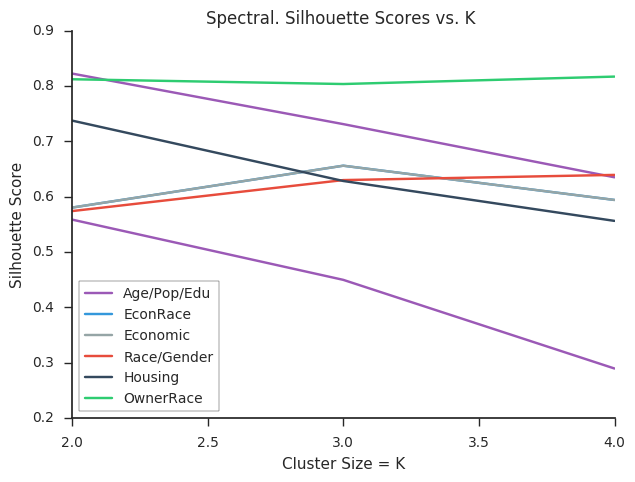

In [359]:
spec.plot(kind='line', title="Spectral. Silhouette Scores vs. K ",figsize=(7,5))
sns.despine()
handles, labels = p1.get_legend_handles_labels()
plt.legend(handles, leg1, loc=3)
plt.ylabel('Silhouette Score')
plt.xlabel('Cluster Size = K')
plt.savefig("spectral_sscores")

In [360]:
kmeans_k_dict, agglo_k_dict, spec_k_dict
merged_k = { p : [kmeans_k_dict[p], agglo_k_dict[p], spec_k_dict[p]] for p in prefix }

merged = {}
for key in merged_k:
    merged[key] = merged_k[key]
for key in merged_scores:
    merged[key] = merged_scores[key]
    

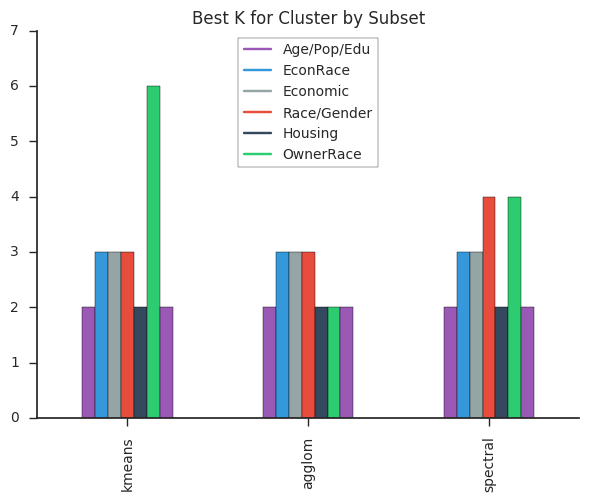

In [361]:
k_fig = plt.figure()
pd.DataFrame(data=merged_k, index=["kmeans", "agglom", "spectral"]).plot(
    kind="bar", ax=k_fig.gca(), title="Best K for Cluster by Subset", yticks=np.arange(8), figsize=(7,5))
sns.despine()
plt.legend(handles, leg1, loc="upper center")
k_fig.savefig("BestKByClustering")

In [348]:
all_dummies = []
all_dummies.extend(kmeans_dummies)
all_dummies.extend(agglo_dummies)
all_dummies.extend(spec_dummies)
all_dummies = pd.Series(all_dummies).drop_duplicates()

cluster_counts = counties[all_dummies].sum()

In [349]:
def extract_dummy_subset(prefix:str):
    rtn = []
    for ele in cluster_counts.index:
        if prefix in ele:
            rtn.append(ele)
            
    return rtn

In [350]:
subset_masks = { p : extract_dummy_subset(p) for p in prefix}
prefix

dict_keys(['economic', 'ethnic', 'voting', 'age_pop_edu', 'housing', 'ownership_race', 'econ_race'])

In [351]:
data_by_subset = {key : counties[subset_masks[key]] for key in kmeans_k_dict.keys()}
data_by_subset["ethnic"].columns

Index(['ethnic_kmeans_0', 'ethnic_kmeans_1', 'ethnic_kmeans_2',
       'ethnic_agglo_0', 'ethnic_agglo_1', 'ethnic_agglo_2',
       'ethnic_spectral_0', 'ethnic_spectral_1', 'ethnic_spectral_2',
       'ethnic_spectral_3'],
      dtype='object')

create subgroups for each clustering type

In [352]:
suffixes = ["kmeans", "agglo", "spectral"]
def get_clusters(key, suf):
    filt = { "kmeans": key+"_kmeans", "agglo" : key+"_agglo", "spectral": key+"_spectral"}
    df = data_by_subset[key].copy()
    cols=[]
    hdrs=df.columns
    for ele in hdrs:
        if filt[suf] in str(ele):
            cols.append(ele)
    
    return df[np.unique(cols)].sum().to_frame().T, len(np.unique(cols))

def plot_cluster(key, suffix, t):
    f = plt.figure()
    df, num_clust = get_clusters(key, suffix)
    p1 = df.plot(kind='bar', ax=f.gca(), title=t + " using " + suffix, figsize=(5,3))
    handles, labels = p1.get_legend_handles_labels()
    leg1=["Cluster" + str(i) for i in range(len(labels))]
    sns.despine()
    plt.legend(handles, leg1, loc=1)
    plt.yticks()
    return plt

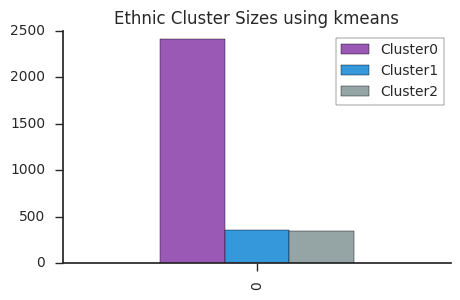

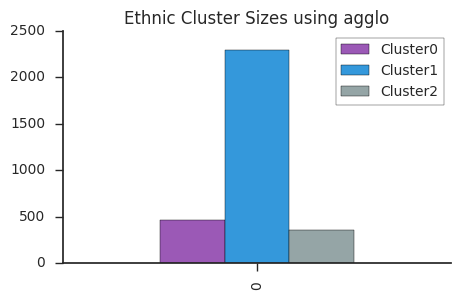

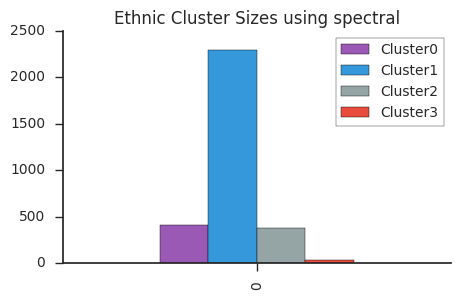

In [336]:
for i in range(3):
    plot_cluster("ethnic", suffixes[i], "Ethnic Cluster Sizes").savefig("size_ethnic_"+suffixes[i])

- a couple of clusters are very large while the rest are very small

In [353]:
# for i in range(3):
#     plot_cluster("age_pop_edu", suffixes[i], "Demographic Cluster Sizes")

- cluster 0 is much smaller than the rest. 

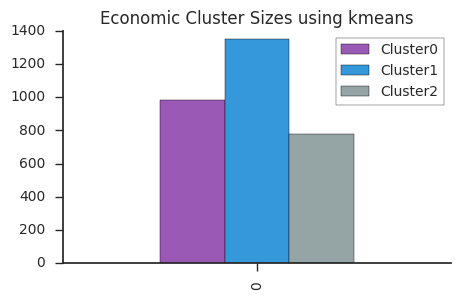

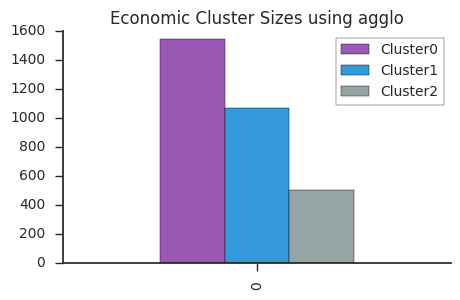

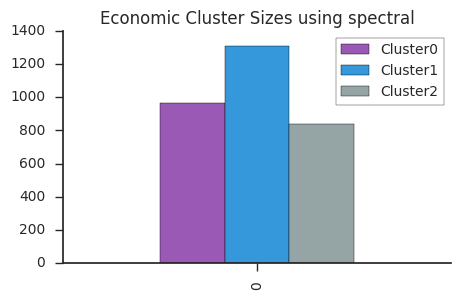

In [354]:
for i in range(3):
    plot_cluster("economic", suffixes[i], "Economic Cluster Sizes").savefig('size_econ_'+suffixes[i])

- cluster 4 seems significantly smaller than others.

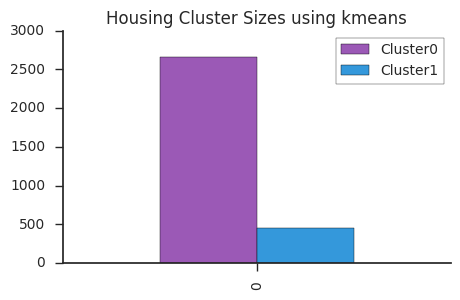

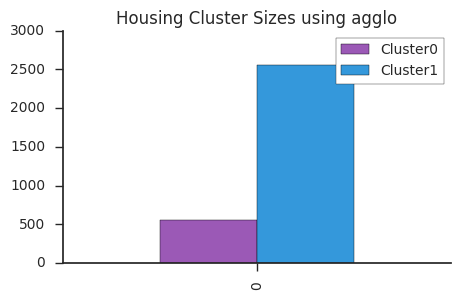

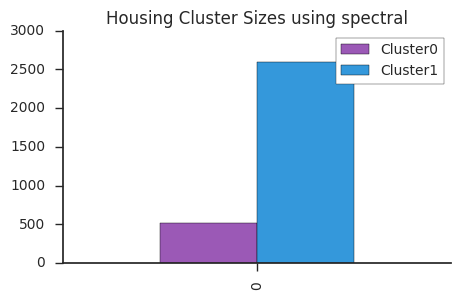

In [339]:
for i in range(3):
    plot_cluster("housing", suffixes[i], "Housing Cluster Sizes").show()

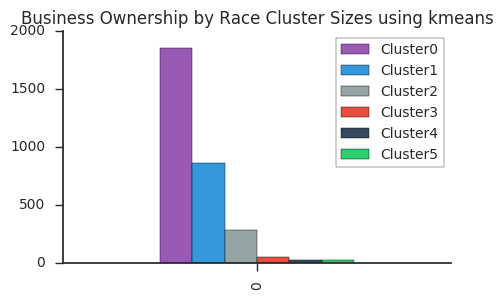

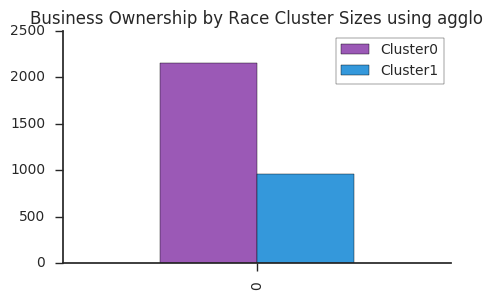

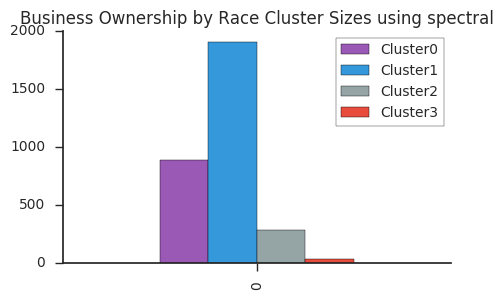

In [362]:
for i in range(3):
    plot_cluster("ownership_race", suffixes[i], "Business Ownership by Race Cluster Sizes").savefig("size_ownership_race"+suffixes[i])

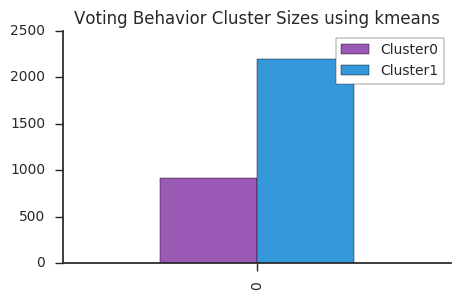

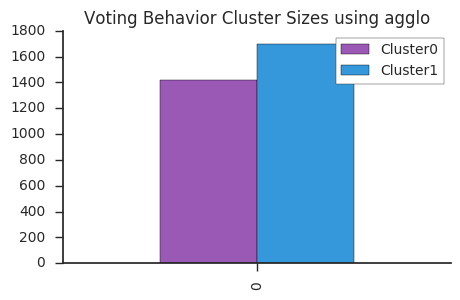

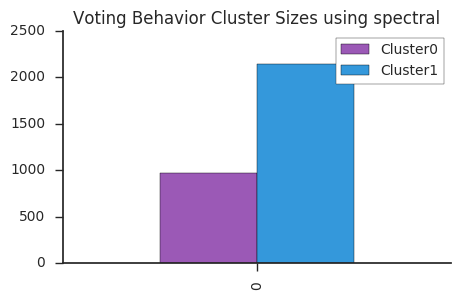

In [341]:
for i in range(3):
    plot_cluster("voting", suffixes[i], "Voting Behavior Cluster Sizes").show()

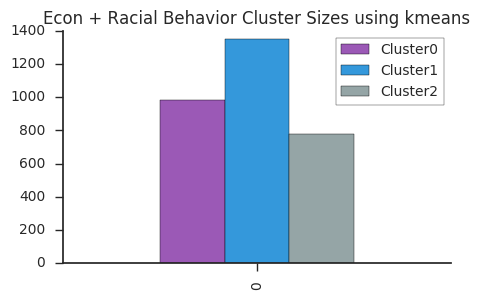

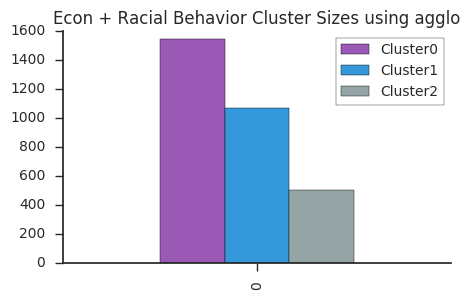

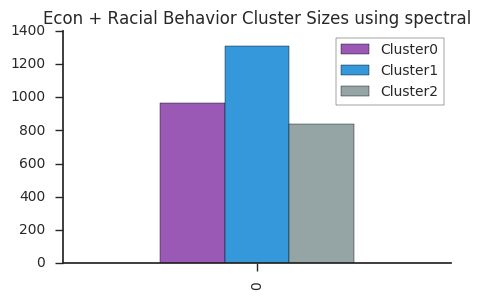

In [355]:
for i in range(3):
    plot_cluster("econ_race", suffixes[i], "Econ + Racial Behavior Cluster Sizes").savefig("size_econ_race_"+ suffixes[i])